# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
#импорт библиотек и настройка отображения 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error 

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from numpy.random import RandomState

!pip install  phik==0.10.0 -q
import phik

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.2f}'.format


RANDOM_STATE = 73
TEST_SIZE = 0.25


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
geo_data_0 = pd.read_csv('C:/Users/Ksenchik/practicum/МО в бизнесе/geo_data_0.csv') 
geo_data_1 = pd.read_csv('C:/Users/Ksenchik/practicum/МО в бизнесе/geo_data_1.csv') 
geo_data_2 = pd.read_csv('C:/Users/Ksenchik/practicum/МО в бизнесе/geo_data_2.csv') 

In [3]:
#функция для расчета количесства строк в столбце, количество заполненных и доли пропусков
def df_info(df, str1 = "-------\n", str2 = "\n\n") :
    print(str1)
    df_size = df.size
    not_na_count = df.notna().sum()
    na_count = df.isna().sum()
    dublicated = df.duplicated().sum()
    
    if df_size == na_count:
        print('Данные отсутствуют')
    elif df_size == 0 :
        print('Данные отсутствуют')
    else:
        print(f"size: {df_size}")
        print(f"na_count: {na_count}")
        print(f"not_na_count: {not_na_count}")
        print(f"na_ratio: {(na_count / df_size):.2f}") 
        print(f"duplicated: {dublicated}") 
        print(f"duplicated_ratio: {(dublicated / df_size):.2f}") 
    print(str2)

In [4]:
#создаем функцию для применения предыдущей функции к каждому столбцу 
def data_info (data, col_name):
    print(col_name)
    df_info(data[col_name])

In [5]:
#смотрим результат для geo_data_0
for el in geo_data_0.columns:
    data_info(geo_data_0, el)
print(geo_data_0.info())
print('Дублей: ', geo_data_0.duplicated().sum())
print(geo_data_0.isna().sum())

id
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 10
duplicated_ratio: 0.00



f0
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 0
duplicated_ratio: 0.00



f1
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 0
duplicated_ratio: 0.00



f2
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 0
duplicated_ratio: 0.00



product
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 0
duplicated_ratio: 0.00



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8

In [6]:
#смотрим результат для geo_data_1
for el in geo_data_1.columns:
    data_info(geo_data_1, el)
print(geo_data_1.info())
print('Дублей: ', geo_data_1.duplicated().sum())
print(geo_data_1.isna().sum())

id
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 4
duplicated_ratio: 0.00



f0
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 0
duplicated_ratio: 0.00



f1
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 0
duplicated_ratio: 0.00



f2
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 0
duplicated_ratio: 0.00



product
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 99988
duplicated_ratio: 1.00



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 

In [7]:
#смотрим результат для geo_data_2
for el in geo_data_2.columns:
    data_info(geo_data_2, el)
print(geo_data_2.info())
print('Дублей: ', geo_data_2.duplicated().sum())
print(geo_data_2.isna().sum())

id
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 4
duplicated_ratio: 0.00



f0
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 0
duplicated_ratio: 0.00



f1
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 0
duplicated_ratio: 0.00



f2
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 0
duplicated_ratio: 0.00



product
-------

size: 100000
na_count: 0
not_na_count: 100000
na_ratio: 0.00
duplicated: 0
duplicated_ratio: 0.00



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+

Данные загружены. Во всех таблицах есть дубликаты по ID скважины. Посмотрим на данные и определимся с дублями 

In [8]:
for i in geo_data_2, geo_data_1, geo_data_0:
    display(i.sample(5))
    print("-------\n Дубли: ")
    display(i[i['id'].duplicated() == True])
    print("-------\n")

,id,f0,f1,f2,product
19337,zOKhd,-0.98,-1.83,0.93,92.63
55002,UpOrk,-1.84,-0.90,6.30,53.17
81955,TgXCf,-0.06,1.27,-0.20,53.80
97720,vELVX,-0.16,-2.52,3.88,50.04
14327,APnsh,2.36,-1.61,2.57,30.85


-------
 Дубли: 


,id,f0,f1,f2,product
43233,xCHr8,-0.85,2.10,5.60,184.39
49564,VF7Jo,-0.88,0.56,0.72,136.23
55967,KUPhW,1.21,3.18,5.54,132.83
95090,Vcm5J,2.59,1.99,2.48,92.33


-------



,id,f0,f1,f2,product
62875,AxzFG,0.92,-5.91,4.00,107.81
52032,sxMdU,-2.51,-5.74,5.00,137.95
65045,Aco6N,-3.90,-9.21,5.00,137.95
94247,6ioGw,-0.47,-5.52,1.99,57.09
44397,xr8GJ,-11.50,10.33,4.99,137.95


-------
 Дубли: 


,id,f0,f1,f2,product
41906,LHZR0,-8.99,-4.29,2.01,57.09
82178,bfPNe,-6.20,-4.82,3.00,84.04
82873,wt4Uk,10.26,-9.38,4.99,134.77
84461,5ltQ6,18.21,2.19,3.99,107.81


-------



,id,f0,f1,f2,product
40038,ROVlX,1.20,-0.41,1.20,37.08
44765,uEXQO,0.05,1.18,2.63,20.96
91033,kDsA4,1.90,0.54,1.28,130.55
16063,Ws5hz,1.70,-0.01,3.70,136.74
81107,z7D3T,0.34,1.04,7.49,114.64


-------
 Дубли: 


,id,f0,f1,f2,product
7530,HZww2,1.06,-0.37,10.43,158.83
41724,bxg6G,-0.82,0.55,3.63,93.01
51970,A5aEY,-0.18,0.94,-2.09,33.02
63593,QcMuo,0.64,-0.47,0.86,64.58
66136,74z30,1.08,-0.31,6.99,127.64
69163,AGS9W,-0.93,0.12,-3.66,19.23
75715,Tdehs,0.11,0.43,3.22,60.96
90815,fiKDv,0.05,0.84,6.39,137.35
92341,TtcGQ,0.11,1.02,0.91,101.32
97785,bsk9y,0.38,0.01,0.16,160.64


-------



Дубли не подтвердились, данные в Id уникальны.

Посмотрим на основную статистику и распределение данных в таблицах 

In [9]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


In [10]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


In [11]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


На первый взгляд критичных выбросов не видно. 


Посмотрим на графики распределения значений - построим гистограммы и ящик с усами для количественных признаков. Поскольку признаков много, сделаем это с помощью функций. 

In [12]:
#сделаем графики всевозможно синими
colors=['aquamarine', 'turquoise', 'lightseagreen', 'mediumturquoise', 'darkturquoise', 'deepskyblue',
        'dodgerblue', 'royalblue', 'cornflowerblue', 'steelblue']

In [13]:
#уберем id из списка столбцов, для которых хотим построить графики
col=['f0', 'f1', 'f2', 'product']

In [14]:
#сооздадим функцию, которая поможет нам с графиками
def visual (df, col):
    df[col].plot(
        kind='hist',
        title=col,
        alpha=0.5,
        color=np.random.choice(colors)
    )
    plt.xlabel(col)
    plt.ylabel('Значение ' + col)
    plt.show();
    
    df[col].plot(
    kind='box',
    title=col,
    color=np.random.choice(colors)
    );
    
    plt.show()

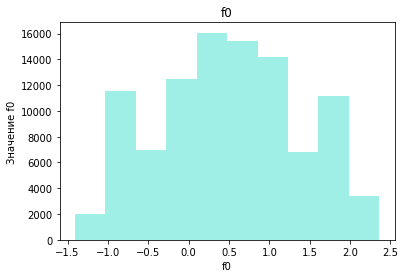

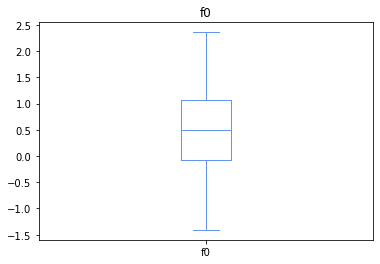

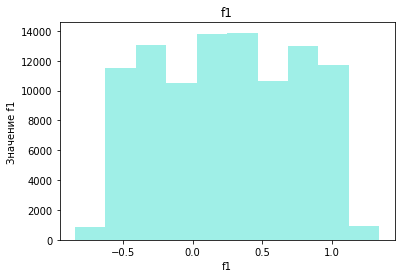

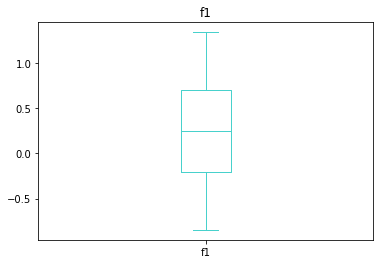

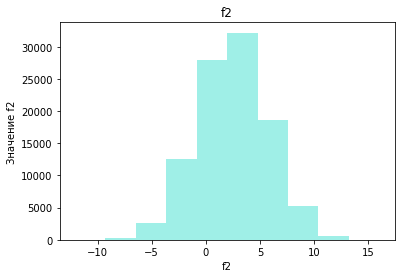

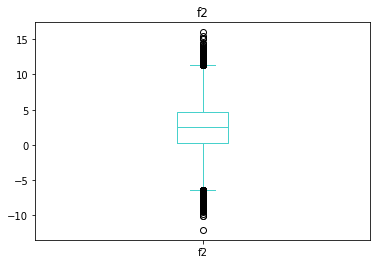

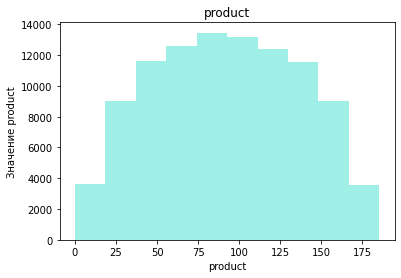

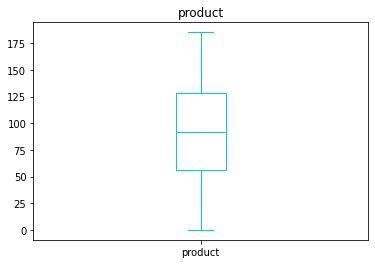

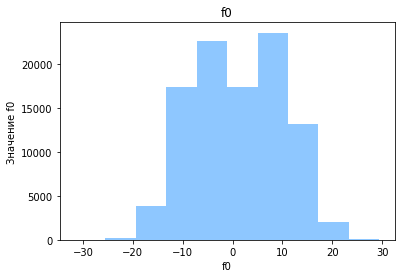

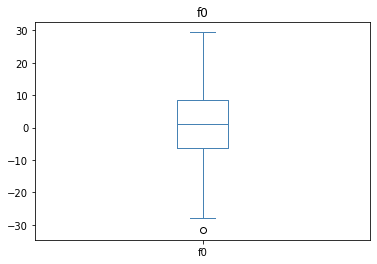

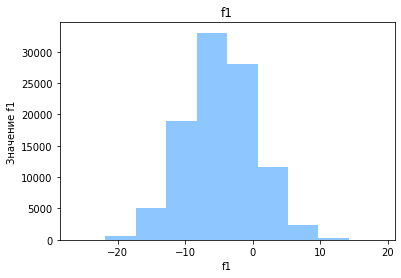

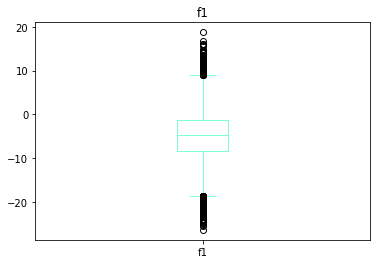

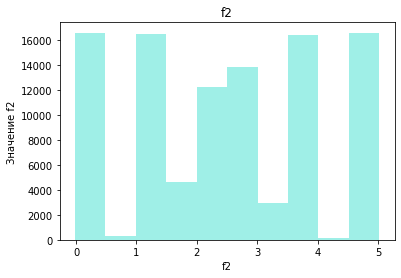

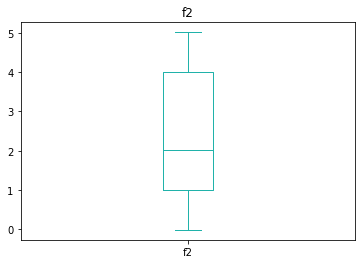

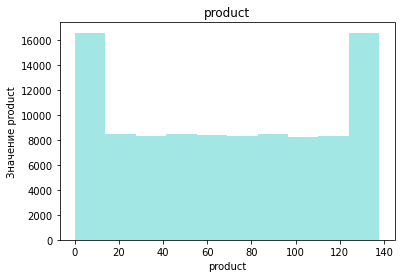

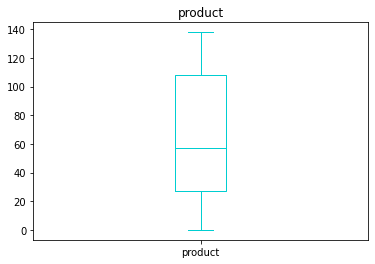

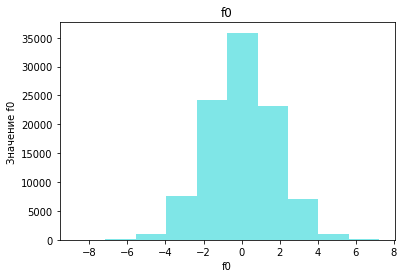

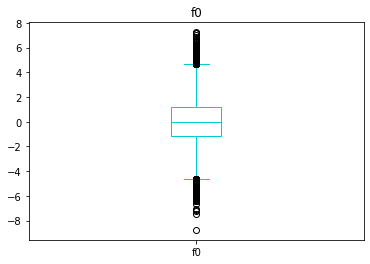

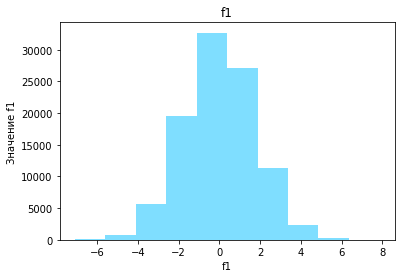

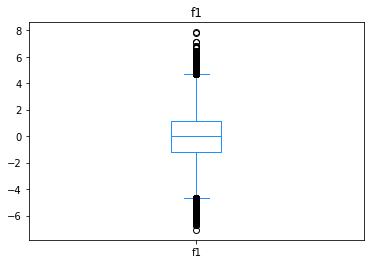

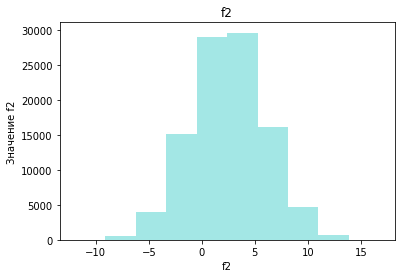

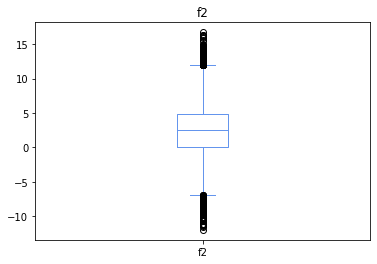

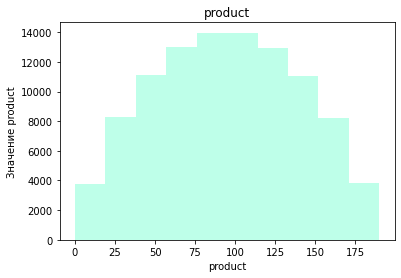

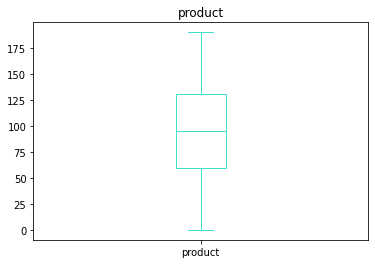

In [15]:
#применим их к каждому столбцу 
for df in geo_data_0[col], geo_data_1[col], geo_data_2[col]:
    for el in df:
        visual(df, el)

Только geo_data_2 имеет нормальное распределение всех признаков. 
В geo_data_0 f0 имеет пики около -1 и -2, f1 тоже не похож на нормальное распределение. 
В geo_data_1 f0 также имеет пики около 10 и -5, f2 вообще предполагает другие знаечения, нежели geo_data_0 - значения распределены по шкале от 0 до 5, а объем запасов в среднем около 8 000 тыс. баррелей, за исключением пиков около 0 и 140. 

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


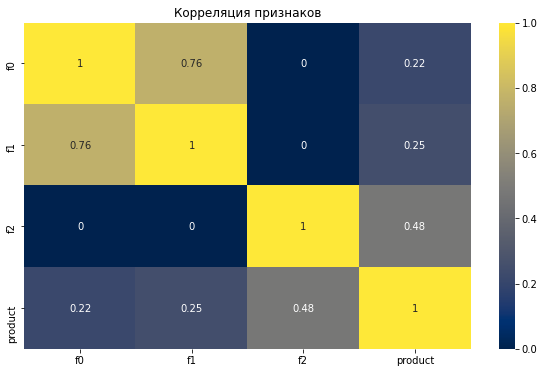

In [16]:
#посмотрим на коэффициенты корреляции между признаками
plt.figure(figsize=(10, 6))
sns.heatmap(geo_data_0[col].phik_matrix(), annot=True, cmap='cividis')
plt.title('Корреляция признаков');

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


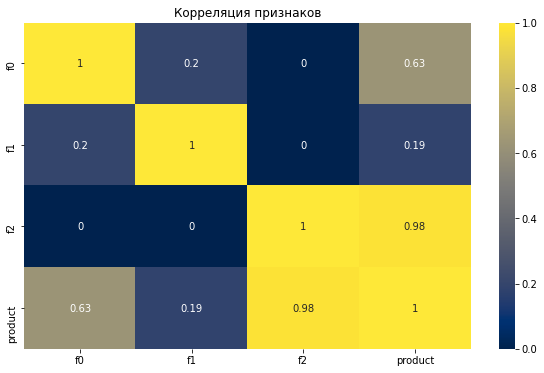

In [17]:
#посмотрим на коэффициенты корреляции между признаками
plt.figure(figsize=(10, 6))
sns.heatmap(geo_data_1[col].phik_matrix(), annot=True, cmap='cividis')
plt.title('Корреляция признаков');

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


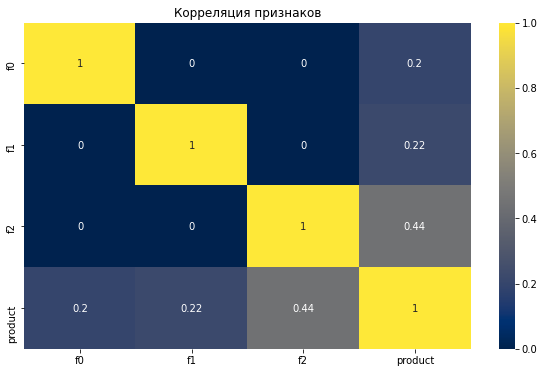

In [18]:
#посмотрим на коэффициенты корреляции между признаками
plt.figure(figsize=(10, 6))
sns.heatmap(geo_data_2[col].phik_matrix(), annot=True, cmap='cividis')
plt.title('Корреляция признаков');

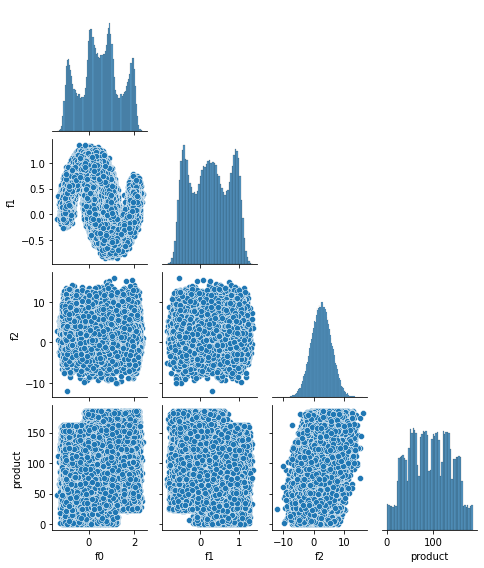

In [19]:
# построим диаграмму рассеяния для geo_data_0
sns.pairplot(
    data=geo_data_0, 
    aspect=.85,
    corner=True,
    height=2);

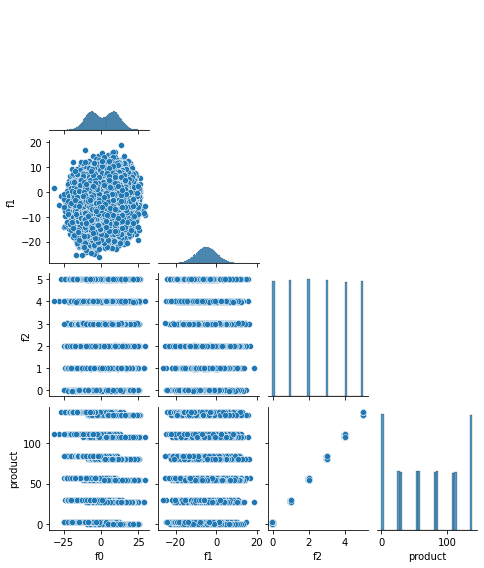

In [20]:
# построим диаграмму рассеяния для geo_data_1
sns.pairplot(
    data=geo_data_1, 
    aspect=.85,
    corner=True,
    height=2);

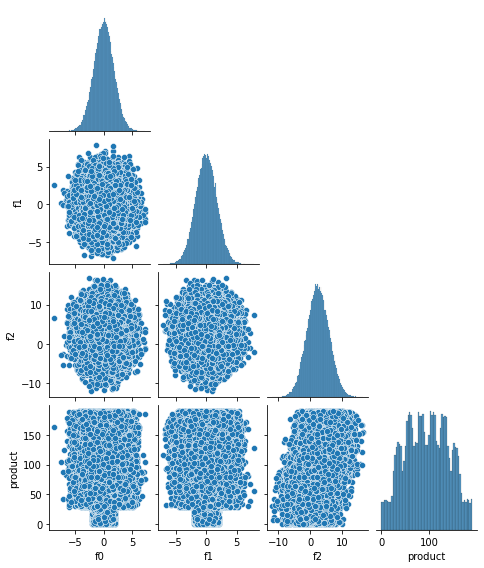

In [21]:
# построим диаграмму рассеяния для geo_data_2
sns.pairplot(
    data=geo_data_2, 
    aspect=.85,
    corner=True,
    height=2);

Корредяция признаков в датасетах неодинакова: 
- в geo_data_0 f1 и f0 имеют между собой сильную связь, в то время как в других датасетах связи слабая или отсутствует;
- geo_data_1 product имеет очень сильную связи с f2, в то время как в других датасетах связь 0,44-0,48.

**Вывод**:
1. Данные успешно загружены, типы данных соответствуют значениям.
2. Нормальное распределение имеют только признаки в регионе geo_data_2
3. По данным графика в таблицах есть выбросы, однако без интерпретации входных признаков делать вывод о наличии выбросов и удалять их / заменять нецелесообразно. Данные оставлены в виде заказчика. 
4. В geo_data_0 f1 и f0 имеют между собой сильную связь, в то время как в других датасетах связи слабая или отсутствует;
5. В geo_data_1 product имеет очень сильную связи с f2, в то время как в других датасетах связь 0,44-0,48.

В целом, данные готовы для построения моделей. 

## Обучение и проверка модели

Поскольку по требованию закзчика мы можем использовать только хорошо интерпретируемую модель линейной регрессии, прочие модели не применялись. 

Обучим три модели для каждого из регионов. 

In [23]:
#обучим модель для geo_data_0
X_0 = geo_data_0.drop(['id', 'product'], axis=1)
y_0 = geo_data_0['product']

# делим данные
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(
    X_0,
    y_0,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

# стандартизируем выборки
scaler = StandardScaler()
X_train_scalled_0 = scaler.fit_transform(X_train_0)
X_valid_scalled_0 = scaler.transform(X_valid_0)


# задаем модель линейной регрессии
model_lr_0  = LinearRegression()

# обучаем модель на тренировочных данных
model_lr_0.fit(X_train_scalled_0, y_train_0)

# получаем предсказания модели на тестовых данных 
predictions_0 = model_lr_0.predict(X_valid_scalled_0)
rmse = mean_squared_error(y_valid_0, predictions_0) ** 0.5
print(f'rmse = {rmse:.2f}')
print(f'Средний запас сырья = {predictions_0.mean():.2f}')



rmse = 37.58
Средний запас сырья = 92.62


In [24]:
#сохраним целевое и предсказанные значения в одном дс
save_0 = pd.DataFrame(y_valid_0)
save_0['predictions'] = predictions_0

In [25]:
#обучим модель для geo_data_1
X_1 = geo_data_1.drop(['id', 'product'], axis=1)
y_1 = geo_data_1['product']

# делим данные
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(
    X_1,
    y_1,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

# стандартизируем выборки
scaler_1 = StandardScaler()
X_train_scalled_1 = scaler.fit_transform(X_train_1)
X_valid_scalled_1 = scaler.transform(X_valid_1)


# задаем модель линейной регрессии
model_lr_1  = LinearRegression()

# обучаем модель на тренировочных данных
model_lr_1.fit(X_train_scalled_1, y_train_1)

# получаем предсказания модели на тестовых данных 
predictions_1 = model_lr_1.predict(X_valid_scalled_1)
rmse = mean_squared_error(y_valid_1, predictions_1) ** 0.5
print(f'rmse = {rmse:.2f}')
print(f'Средний запас сырья = {predictions_1.mean():.2f}')

rmse = 0.89
Средний запас сырья = 69.08


Снизить ошибку добавлением новых признаков (f0 в кварате, f1 в третьей степени или суммой f1 + f2) не удалось. 
Ошибка, как и средний запас сырья, незначительно, но растут. Исключать же f2 тоже нецелесообразно - прямая связь в линейной модели нужна (и да, опытна=ым путем выявлено, что при удалении f2 ошибка падает вдвое, как и средний запас сырья).

Оставим данные без изменений входных признаков

In [26]:
#сохраним целевое и предсказанные значения в одном дс
save_1 = pd.DataFrame(y_valid_1)
save_1['predictions'] = predictions_1

In [27]:
#обучим модель для geo_data_2
X_2 = geo_data_2.drop(['id', 'product'], axis=1)
y_2 = geo_data_2['product']

# делим данные
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(
    X_2,
    y_2,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

# стандартизируем выборки
scaler_2 = StandardScaler()
X_train_scalled_2 = scaler.fit_transform(X_train_2)
X_valid_scalled_2 = scaler.transform(X_valid_2)


# задаем модель линейной регрессии
model_lr_2  = LinearRegression()

# обучаем модель на тренировочных данных
model_lr_2.fit(X_train_scalled_2, y_train_2)

# получаем предсказания модели на тестовых данных 
predictions_2 = model_lr_2.predict(X_valid_scalled_2)
rmse = mean_squared_error(y_valid_2, predictions_2) ** 0.5
print(f'rmse = {rmse:.2f}')
print(f'Средний запас сырья = {predictions_2.mean():.2f}')

rmse = 40.09
Средний запас сырья = 94.91


In [28]:
#сохраним целевое и предсказанные значения в одном дс
save_2 = pd.DataFrame(y_valid_2)
save_2['predictions'] = predictions_2

Для каждого региона обучена модели, рассчитана ошибка и средний запас сырья, фактические и предсказанные значения сохранены. 


In [29]:
def func(df):
    #обучим модель для geo_data_2
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']

    # делим данные
    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE)

    # стандартизируем выборки
    scaler = StandardScaler()
    X_train_scalled = scaler.fit_transform(X_train)
    X_valid_scalled = scaler.transform(X_valid)


    # задаем модель линейной регрессии
    model_lr  = LinearRegression()

    # обучаем модель на тренировочных данных
    model_lr.fit(X_train_scalled, y_train)

    # получаем предсказания модели на тестовых данных 
    predictions = model_lr.predict(X_valid_scalled)
    rmse = mean_squared_error(y_valid, predictions) ** 0.5
    print(f'rmse = {rmse:.2f}')
    print(f'Средний запас сырья = {predictions.mean():.2f}')

In [30]:
func(geo_data_2)

rmse = 40.09
Средний запас сырья = 94.91


## Подготовка к расчёту прибыли

In [31]:
#сохраним значения для расчетов
budget = 10000000000
income = 450000
target_points = 200
max_points = 500

In [32]:
#рассчитаем достаточный объём сырья для безубыточной разработки новой скважины
profit = budget / (income * target_points)
profit

111.11111111111111

Вывод: ни один регион не отвечает требованию по достаточности объема сырья по среднему запасу сырья. Посмотрим, изменится ли решение по выбранным скважинам. 

## Расчёт прибыли и рисков 

Для начала посчитаем по всем предсказанным значениям запас сырья и прибыль. 

In [33]:
#создадим функцию для расчета прибыли от региона
def profit_geo(df):
    raw_materials = df.sort_values(by='predictions', ascending=False).head(target_points)['product']
    profit_geo = raw_materials.sum().round()
    return profit_geo

In [34]:
#применим функцию для региона 0
print(f'Запас сырья = {profit_geo(save_0)}')
print(f'Прибыль от региона = {profit_geo(save_0)*income-budget}')

Запас сырья = 29339.0
Прибыль от региона = 3202550000.0


In [35]:
#применим функцию для региона 1
print(f'Запас сырья = {profit_geo(save_1)}')
print(f'Прибыль от региона = {profit_geo(save_1)*income-budget}')

Запас сырья = 27589.0
Прибыль от региона = 2415050000.0


In [36]:
#применим функцию для региона 2
print(f'Запас сырья = {profit_geo(save_2)}')
print(f'Прибыль от региона = {profit_geo(save_2)*income-budget}')

Запас сырья = 27803.0
Прибыль от региона = 2511350000.0


Теперь отберем случайным образом 500 скважин 1000 раз, посчитаем для каждого случая среднее, прибыль и убытки.
Сравним средние значения, полученые таким образом по каждому региону. 

In [37]:
#создадим функцию, чтобы избежать лишних повторений
def conclusion2(df):
    #зададим случайность, чтобы выборки каждый раз менялись 
    state = RandomState(12345) 

    #пустой список для наших расчетов
    values = []
    #для 1000 повторений
    for i in range(1000):
        #создадим случайную выборку в 500 значений
        subsample = df.sample(max_points, replace=True, random_state=state)
        #выберем из этих 500 значений по предсказаниям лучшие 200 и посчитаем прибыль (ну, или убыток)
        mur = profit_geo(subsample)*income-budget
        #сохраним в списке
        values.append(mur)

    #сделаем из списка Series, чтобы удобнее с ним работать 
    values = pd.Series(values)

    # помним про доверительный интервал
    lower = values.quantile(0.025).round()
    upper = values.quantile(0.975).round()

    #наконец, выведем итог
    print('Доверительный интервал: ', lower, ' - ', upper)
    print(f'Прибыль от региона = {values.mean().round(2)}')
    print(f'Риск = {(values.apply(lambda x: x < 0).sum()/len(values)*100).round(2)}%')

In [38]:
print('Данные для нулевого региона: ')
conclusion2(save_0)

Данные для нулевого региона: 
Доверительный интервал:  -81178750.0  -  979718750.0
Прибыль от региона = 473601950.0
Риск = 4.3%


In [39]:
print('Данные для первого региона: ')
conclusion2(save_1)

Данные для первого региона: 
Доверительный интервал:  84095000.0  -  849623750.0
Прибыль от региона = 470559050.0
Риск = 1.4%


In [40]:
print('Данные для второго региона: ')
conclusion2(save_2)

Данные для второго региона: 
Доверительный интервал:  -119620000.0  -  878142500.0
Прибыль от региона = 388279250.0
Риск = 6.7%


Очевидно, по условиям заказчика подойдет только первый регион - риск региона составляет допустимые 1,4%. 

**Вывод**:
1. Данные успешно загружены. На этапе предобработки данных выявлены выбросы, однако при отсутствии пояснений к входным признакам их обработка не проводилась. Все данные заказчика использованы в полном объеме.
2. Для каждого региона построена модель линейной регрессии. Важно: модель для первого региона дает наибольшую ошибку.
3. Для каждого региона рассчитаны: доверительный интервал, средняя прибыль и убытки. 

**Выбор локации**
Ни один из реионов не отвечает требованиям по среднему запасу сырья, при этом выбранные скважины позволяют получить достаточную прибыль.
Для разработки предлагается регион под номером 1, т.к. имеет допустимуб долю рисков (1,4% при лимите 2,5%), самую высокую среднюю прибыль. 


*На подумать*

Модель для первого региона показывает самую большую ошибку. Если возможно, следует добавить пояснения к входным признакам для их корректной обработки, чтобы снизить ошибку модели. 
